Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Test Loss: 4.49087858701226e-05


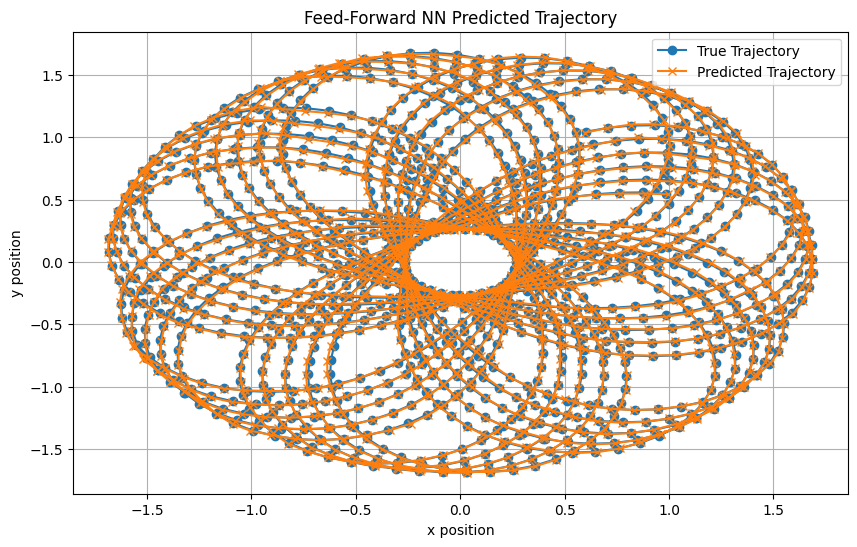

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from src.dataset import get_dataloaders
from src.network import FeedForwardNN, RecurrentNN
from train import train_model, evaluate_model

batch_size = 64
num_epochs = 100


def load_data(file_path):
    data = np.loadtxt(file_path)
    velocities = data[:, :2]
    positions = data[:, 2:]
    return velocities, positions

train_velocities, train_positions = load_data('data_lorentz/train.txt')
test_velocities, test_positions = load_data('data_lorentz/test.txt')

# Create input-output pairs for training
def create_pairs(velocities, positions):
    input_states = np.hstack((velocities[:-1], positions[:-1]))
    output_states = np.hstack((velocities[1:], positions[1:]))
    return input_states, output_states

train_input_states, train_output_states = create_pairs(train_velocities, train_positions)
test_input_states, test_output_states = create_pairs(test_velocities, test_positions)

# Convert data to PyTorch tensors
train_input_states = torch.tensor(train_input_states, dtype=torch.float32)
train_output_states = torch.tensor(train_output_states, dtype=torch.float32)
test_input_states = torch.tensor(test_input_states, dtype=torch.float32)
test_output_states = torch.tensor(test_output_states, dtype=torch.float32)

# Create dataset and dataloader
train_dataset = torch.utils.data.TensorDataset(train_input_states, train_output_states)
test_dataset = torch.utils.data.TensorDataset(test_input_states, test_output_states)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Instantiate the model, define loss function and optimizer
model = FeedForwardNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, criterion, optimizer, num_epochs)
evaluate_model(model, test_loader, criterion)

# Visualization functions
def plot_positions(positions, title):
    x = positions[:, 0]
    y = positions[:, 1]
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o')
    plt.title(title)
    plt.xlabel('x position')
    plt.ylabel('y position')
    plt.grid(True)
    plt.show()

def plot_predicted_trajectories(model, input_states, true_positions, title):
    model.eval()
    with torch.no_grad():
        predicted_states = model(input_states).numpy()
    
    predicted_positions = predicted_states[:, 2:]  # Extract predicted positions
    
    plt.figure(figsize=(10, 6))
    plt.plot(true_positions[:, 0], true_positions[:, 1], label='True Trajectory', marker='o')
    plt.plot(predicted_positions[:, 0], predicted_positions[:, 1], label='Predicted Trajectory', marker='x')
    plt.title(title)
    plt.xlabel('x position')
    plt.ylabel('y position')
    plt.legend()
    plt.grid(True)
    plt.show()

# Prepare input data for plotting predicted trajectories
test_input_states_np = test_input_states.numpy()
test_output_positions_np = test_output_states[:, 2:].numpy()

# Plot predicted trajectories for feed-forward neural network
plot_predicted_trajectories(model, test_input_states, test_output_positions_np, 'Feed-Forward NN Predicted Trajectory')


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Test Loss: 5.998531128722306e-05


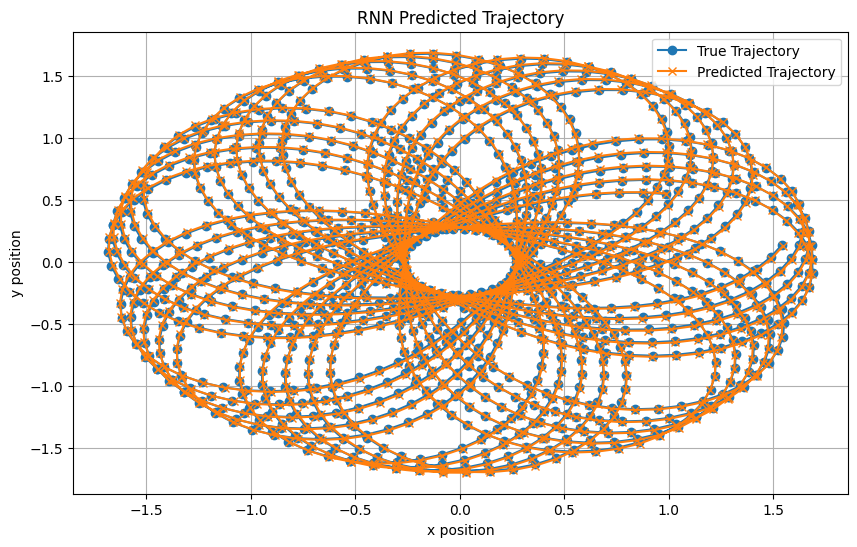

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from src.dataset import get_dataloaders
from src.network import FeedForwardNN, RecurrentNN
from train import train_model, evaluate_model

from tqdm.auto import tqdm

batch_size = 64
num_epochs = 100

# Visualization functions
def plot_positions(positions, title):
    x = positions[:, 0]
    y = positions[:, 1]
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o')
    plt.title(title)
    plt.xlabel('x position')
    plt.ylabel('y position')
    plt.grid(True)
    plt.show()

def plot_predicted_trajectories(model, dataloader, title, seq_length=5):
    model.eval()
    true_positions = []
    predicted_positions = []

    with torch.no_grad():
        for input_sequences, output_sequences in dataloader:
            predicted_sequences = model(input_sequences).numpy()
            true_positions.append(output_sequences[:, -1, 2:])  # Last position in the sequence
            predicted_positions.append(predicted_sequences[:, -1, 2:])  # Last predicted position in the sequence
    
    true_positions = np.concatenate(true_positions)
    predicted_positions = np.concatenate(predicted_positions)
    
    plt.figure(figsize=(10, 6))
    plt.plot(true_positions[:, 0], true_positions[:, 1], label='True Trajectory', marker='o')
    plt.plot(predicted_positions[:, 0], predicted_positions[:, 1], label='Predicted Trajectory', marker='x')
    plt.title(title)
    plt.xlabel('x position')
    plt.ylabel('y position')
    plt.legend()
    plt.grid(True)
    plt.show()

# Prepare input data for plotting predicted trajectories
def extract_positions(dataloader):
    positions = []
    for _, output_sequences in dataloader:
        positions.append(output_sequences[:, -1, 2:].numpy())
    return np.concatenate(positions)

# Get dataloaders
train_loader, test_loader = get_dataloaders(batch_size, "data_lorentz/train.txt", "data_lorentz/test.txt", seq_length=16)

# Instantiate the RNN model, define loss function and optimizer
rnn_model = RecurrentNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# Train the RNN model
train_model(rnn_model, train_loader, criterion, optimizer, num_epochs=num_epochs)
# Evaluate the RNN model
evaluate_model(rnn_model, test_loader, criterion)

# Plot predicted trajectories for recurrent neural network
plot_predicted_trajectories(rnn_model, test_loader, 'RNN Predicted Trajectory')


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from src.dataset import get_dataloaders
from src.network import FeedForwardNN, RecurrentNN
from train import train_model, evaluate_model

from tqdm.auto import tqdm

batch_size = 64
seq_length = 16
num_epochs = 100


def plot_positions(positions, title):
    x = positions[:, 0]
    y = positions[:, 1]
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o')
    plt.title(title)
    plt.xlabel('x position')
    plt.ylabel('y position')
    plt.grid(True)
    plt.show()

def plot_predicted_trajectories(model, initial_state, steps, title):
    model.eval()
    predicted_positions = []
    predicted_velocities = []

    state = initial_state.unsqueeze(0)
    with torch.no_grad():
        for _ in range(steps):
            output = model(state)
            state = output.unsqueeze(0)
            predicted_velocities.append(output[:, :2].numpy())
            predicted_positions.append(output[:, 2:].numpy())

    predicted_positions = np.concatenate(predicted_positions)
    predicted_velocities = np.concatenate(predicted_velocities)
    
    plt.figure(figsize=(10, 6))
    plt.plot(predicted_positions[:, 0], predicted_positions[:, 1], label='Predicted Trajectory', marker='x')
    plt.title(title)
    plt.xlabel('x position')
    plt.ylabel('y position')
    plt.legend()
    plt.grid(True)
    plt.show()

    return predicted_positions, predicted_velocities


train_loader, test_loader = get_dataloaders(batch_size, "data_lorentz/train.txt", "data_lorentz/test.txt", seq_length=seq_length)

# Instantiate the RNN model, define loss function and optimizer
rnn_model = RecurrentNN(input_size=4, hidden_size=64, output_size=4, num_layers=4)
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# Train the RNN model
train_model(rnn_model, train_loader, criterion, optimizer, num_epochs=num_epochs)

# Evaluate the RNN model
evaluate_model(rnn_model, test_loader, criterion)

# Extract initial state for prediction
initial_state = test_loader.dataset.tensors[0][0]

# Predict trajectories for 300 steps
predicted_positions, predicted_velocities = plot_predicted_trajectories(rnn_model, initial_state, 300, 'RNN Predicted Trajectory')

# Calculate and plot mean squared error (MSE) as a function of time
true_positions = test_loader.dataset.tensors[1][:300, 2:].numpy()
mse = np.mean((true_positions - predicted_positions) ** 2, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(mse, marker='o')
plt.title('Mean Squared Error (MSE) Over Time')
plt.xlabel('Time step')
plt.ylabel('MSE')
plt.grid(True)
plt.show()


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Test Loss: 0.0001328162837731514


ValueError: RNN: Expected input to be 2D or 3D, got 4D tensor instead